In [1]:
import pandas as pd

labels_path = "../dataset/reduced/unprocessed_train_reduced.csv"
df = pd.read_csv(labels_path)
df.head(3)

,Unnamed: 0,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2,2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0


In [2]:
df.shape

(2886, 16)

# Some (not even exploratory) data analysis

Let us analysis the columns to ensure that they are the values we expect. We want to ensure that:
1. For any `healthy` and `injury` column only one or the other occurs (e.g. cannot be both `healthy=1` and `injury=1`)
2. We want to ensure `_low` and `_high` also sum to one

In [3]:
checks = [
    df[(df["bowel_healthy"] == 1) & (df["bowel_injury"] == 1)],
    df[(df["bowel_healthy"] == 0) & (df["bowel_injury"] == 0)],
    df[(df["extravasation_healthy"] == 1) & (df["extravasation_injury"] == 1)],
    df[(df["extravasation_healthy"] == 0) & (df["extravasation_injury"] == 0)],
    df[(df["kidney_low"] == 1) & (df["kidney_high"] == 1)],
    df[(df["liver_low"] == 1) & (df["liver_high"] == 1)],
    df[(df["spleen_low"] == 1) & (df["spleen_high"] == 1)],
    df[(df["kidney_healthy"] == 0) & (df["kidney_low"] == 0) & (df["kidney_high"] == 0)],
    df[(df["liver_healthy"] == 0) & (df["liver_low"] == 1) & (df["liver_high"] == 1)],
    df[(df["spleen_healthy"] == 0) & (df["spleen_low"] == 1) & (df["spleen_high"] == 1)],
]

for check in checks:
    assert len(check) == 0

In [4]:
df["bowel"] = (df["bowel_injury"] == 1).astype(int) # bowel is either injured or not
df["extravastion"] = (df["extravasation_injury"] == 1).astype(int)
df["kidney"] = (df["kidney_healthy"] == 0).astype(int)
df["liver"] = (df["liver_healthy"] == 0).astype(int)
df["spleen"] = (df["spleen_healthy"] == 0).astype(int)

In [5]:
print(df["bowel"].value_counts())
print(df["extravastion"].value_counts())
print(df["kidney"].value_counts())
print(df["liver"].value_counts())
print(df["spleen"].value_counts())

bowel
0    2827
1      59
Name: count, dtype: int64
extravastion
0    2697
1     189
Name: count, dtype: int64
kidney
0    2718
1     168
Name: count, dtype: int64
liver
0    2585
1     301
Name: count, dtype: int64
spleen
0    2552
1     334
Name: count, dtype: int64


In [6]:
new_df = df[["patient_id", "bowel", "extravastion", "kidney", "liver", "spleen"]]
new_df.head()

,patient_id,bowel,extravastion,kidney,liver,spleen
0,10004,0,1,1,0,1
1,10005,0,0,0,0,0
2,10007,0,0,0,0,0
3,10026,0,0,0,0,0
4,10051,0,0,0,0,1


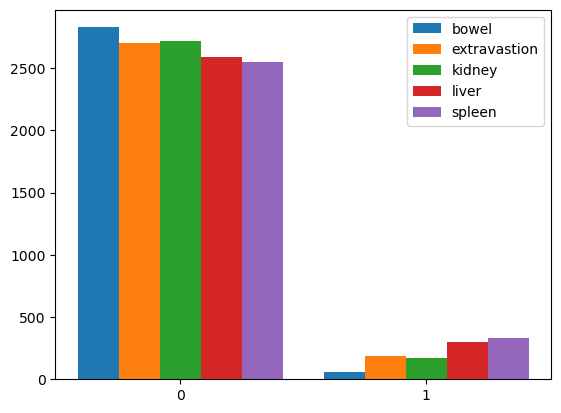

In [11]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()

b_heights, b_bins = np.histogram(new_df['bowel'],bins=[-0.5,0.5,1.5])
e_heights, e_bins = np.histogram(new_df['extravastion'], bins=b_bins)
k_heights, k_bins = np.histogram(new_df['kidney'], bins=e_bins)
l_heights, l_bins = np.histogram(new_df['liver'], bins=k_bins)
s_heights, s_bins = np.histogram(new_df['spleen'], bins=l_bins)


width = (b_bins[1] - b_bins[0])/6.0

ax.bar(b_bins[:-1]+width, b_heights, width=width)
ax.bar(e_bins[:-1]+width*2, e_heights, width=width)
ax.bar(k_bins[:-1]+width*3, k_heights, width=width)
ax.bar(l_bins[:-1]+width*4, l_heights, width=width)
ax.bar(s_bins[:-1]+width*5, s_heights, width=width)
ax.get_xaxis().set_ticks([0.0, 1.0])

plt.legend(["bowel", "extravastion", "kidney", "liver", "spleen"], loc="upper right")
plt.show()

We notice that the dataset is quite imbalanced towards non-injured organs. Definitely a good thing for patients! But a bad thing for training our model.

## Class Imbalances

One idea we can attempt is to weight the loss function.

Here is a reference of how we will attempt to balance our dataset by weighting the loss function: https://discuss.pytorch.org/t/multi-label-multi-class-class-imbalance/37573/17

In [24]:
print(df["bowel"].value_counts())
print(df["bowel"].value_counts()[0])
print(df["bowel"].value_counts()[1])

bowel
0    2827
1      59
Name: count, dtype: int64
2827
59


In [30]:
weights = {
    "bowel": df["bowel"].value_counts()[0] / df["bowel"].value_counts()[1],
    "extravastion": df["extravastion"].value_counts()[0] / df["extravastion"].value_counts()[1],
    "kidney": df["kidney"].value_counts()[0] / df["kidney"].value_counts()[1],
    "liver": df["liver"].value_counts()[0] / df["liver"].value_counts()[1],
    "spleen": df["spleen"].value_counts()[0] / df["spleen"].value_counts()[1]
}

total = sum(weights.values())
normalized_data = {key: round(value / total, 5) for key, value in weights.items()}
normalized_data

{'bowel': 0.50654,
 'extravastion': 0.15086,
 'kidney': 0.17103,
 'liver': 0.09079,
 'spleen': 0.08078}

# Saving new labels

In [10]:
import os
new_df.to_csv(os.path.join("../dataset/reduced/", "train.csv"), index=False)